# Chapter 16 - Natural Language Processing with RNNs and Attention

### Ensure GPU Env is working correctly

In [1]:
import tensorflow as tf
import os
from tensorflow import keras

In [2]:
tf.__version__

'2.6.0'

In [3]:
keras.__version__

'2.6.0'

In [4]:
print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


## Additional Libraries

In [3]:
import numpy as np
import pandas as pd
import os 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

## Char-RNNs

How we can split a sequence into batches of shuffled windows

So now, if we wanted to split a sequence that have 14 in it, we could split it into windows of length 5. We could also shift by a factor of 2 so for example we would have: [0, 1, 2, 3, 4], [2, 3, 4, 5, 6], etc.), then shuffle and split into targets with first 4 and last 4 steps like: [[2, 3, 4, 5], [3, 4, 5, 6]]):

In [6]:
n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[ 6  7  8  9]
 [ 8  9 10 11]
 [ 4  5  6  7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 9 10 11 12]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[10 11 12 13]
 [ 2  3  4  5]
 [ 0  1  2  3]]
===== 
Y_batch
[[11 12 13 14]
 [ 3  4  5  6]
 [ 1  2  3  4]]


## Loading in Shakespeare dataset

In [7]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [8]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [9]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [11]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [12]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [13]:
tokenizer.sequences_to_texts([[0, 1, 2, 3, 4]])

['  e t o']

In [14]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [15]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [16]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [17]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [18]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [19]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [20]:
dataset = dataset.prefetch(1)

In [21]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

In [22]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                    dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                    dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 338s 10ms/step - loss: 1.6189
Epoch 2/10
31368/31368 [==============================] - 350s 11ms/step - loss: 1.5389
Epoch 3/10
31368/31368 [==============================] - 349s 11ms/step - loss: 1.5186
Epoch 4/10
31368/31368 [==============================] - 349s 11ms/step - loss: 1.5073
Epoch 5/10
31368/31368 [==============================] - 349s 11ms/step - loss: 1.4995
Epoch 6/10
31368/31368 [==============================] - 351s 11ms/step - loss: 1.4945
Epoch 7/10
31368/31368 [==============================] - 351s 11ms/step - loss: 1.4904
Epoch 8/10
31368/31368 [==============================] - 352s 11ms/step - loss: 1.4872
Epoch 9/10
31368/31368 [==============================] - 346s 11ms/step - loss: 1.4846
Epoch 10/10
31368/31368 [==============================] - 346s 11ms/step - loss: 1.4834


## Now to use the model to generate some text

In [23]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [24]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [25]:
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 2, 1, 1, 1, 0,
        2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0]],
      dtype=int64)

In [26]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) +1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [27]:
next_char("How are yo", temperature=1)

'u'

In [28]:
next_char("Where is h", temperature=1)

'e'

In [29]:
def complete_text(text, N_chars=50, temperature=1):
    for i in range (N_chars):
        text += next_char(text, temperature)
    return text

In [30]:
print(complete_text("t", temperature=0.2))

t in all she shall be so,
and see the elder for a s


In [31]:
print(complete_text("t", temperature=2.0))

th d; when you'at blood with.

bidnar: you do,
rape


In [32]:
print(complete_text("t", temperature=1.0))

this wholeoullst your dreams.

grumio:
what dost i 


## Stateful RNNs

In [33]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [34]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [35]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [36]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [37]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50, callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 5s 11ms/step - loss: 2.6180
Epoch 2/50
313/313 [==============================] - 3s 11ms/step - loss: 2.2424
Epoch 3/50
313/313 [==============================] - 3s 11ms/step - loss: 2.1127
Epoch 4/50
313/313 [==============================] - 3s 11ms/step - loss: 2.0376
Epoch 5/50
313/313 [==============================] - 3s 11ms/step - loss: 1.9861
Epoch 6/50
313/313 [==============================] - 3s 11ms/step - loss: 1.9496
Epoch 7/50
313/313 [==============================] - 3s 11ms/step - loss: 1.9217
Epoch 8/50
313/313 [==============================] - 3s 11ms/step - loss: 1.9001
Epoch 9/50
313/313 [==============================] - 3s 11ms/step - loss: 1.8847
Epoch 10/50
313/313 [==============================] - 3s 11ms/step - loss: 1.8673
Epoch 11/50
313/313 [==============================] - 3s 11ms/step - loss: 1.8532
Epoch 12/50
313/313 [==============================] - 3s 11ms/step - loss: 1.8417
Epoch 13/50
3

In [38]:
# stateless model with different batch sizes
stateless = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

In [39]:
# build weighless model

stateless.build(tf.TensorShape([None, None, max_id]))

In [40]:
stateless.set_weights(model.get_weights())
model = stateless

In [41]:
print(complete_text("t"))

tenthinks
go meanted my ghodsion that would revengu


## Sentiment Analysis

In [42]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

In [43]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [44]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [45]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [46]:
datasets.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [47]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [48]:
train_size, test_size

(25000, 25000)

In [49]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:300], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda pi ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Cons ...
Label: 0 = Negative



In [50]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0 ,300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [51]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [52]:
from collections import Counter

vocab = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocab.update(list(review.numpy()))

In [53]:
vocab.most_common()[:4] # top 4 common occurences

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564), (b'of', 33983)]

In [54]:
len(vocab)

53893

In [55]:
vocab_size = 10000 #cut down to 10000
truncate_vocab = [word  for word, count in vocab.most_common()[:vocab_size]]

In [56]:
word_to_id = {word: index for index, word in enumerate(truncate_vocab)}
for word in b"This film was increeedddddibbble".split():
    print(word_to_id.get(word) or vocab_size)

22
15
11
10000


In the above example, the final word is outside of our most common list of 10000, so it defaults to that.

In [59]:
words = tf.constant(truncate_vocab)
word_ids = tf.range(len(truncate_vocab), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, oov_buckets)

In [60]:
table.lookup(tf.constant([b"This film was increeedddddibbble".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    15,    11, 10790]], dtype=int64)>

In [62]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [63]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [67]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + oov_buckets, embed_size,
                          mask_zero=True,
                          input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 19s 17ms/step - loss: 0.5438 - accuracy: 0.7170
Epoch 2/5
782/782 [==============================] - 14s 17ms/step - loss: 0.3507 - accuracy: 0.8552
Epoch 3/5
782/782 [==============================] - 14s 17ms/step - loss: 0.1873 - accuracy: 0.9346
Epoch 4/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1417 - accuracy: 0.9497
Epoch 5/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1104 - accuracy: 0.9604


In [68]:
# with manual masking
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 18s 17ms/step - loss: 0.5345 - accuracy: 0.7238
Epoch 2/5
782/782 [==============================] - 14s 17ms/step - loss: 0.3398 - accuracy: 0.8586
Epoch 3/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1836 - accuracy: 0.9342
Epoch 4/5
782/782 [==============================] - 14s 17ms/step - loss: 0.1409 - accuracy: 0.9482
Epoch 5/5
782/782 [==============================] - 14s 18ms/step - loss: 0.1017 - accuracy: 0.9640


## Reusing Pretrained Embeddings

In [69]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [70]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [71]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\saved_model.pb
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\assets\tokens.txt
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.data-00000-of-00001
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.index


In [72]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5454 - accuracy: 0.7284
Epoch 2/5
782/782 [==============================] - 5s 7ms/step - loss: 0.5147 - accuracy: 0.7478
Epoch 3/5
782/782 [==============================] - 5s 7ms/step - loss: 0.5093 - accuracy: 0.7518
Epoch 4/5
782/782 [==============================] - 5s 7ms/step - loss: 0.5056 - accuracy: 0.7544
Epoch 5/5
782/782 [==============================] - 5s 7ms/step - loss: 0.5028 - accuracy: 0.7567


## Automatic Translation

In [73]:
vocab_size = 100
embed_size = 10

In [74]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [75]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [76]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 4s 77ms/step - loss: 4.6054
Epoch 2/2
32/32 [==============================] - 2s 77ms/step - loss: 4.6038


### Bidirectional Recurrent Layers

In [77]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [81]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1:
            max_dims += 1 # max_dims needs to be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [82]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

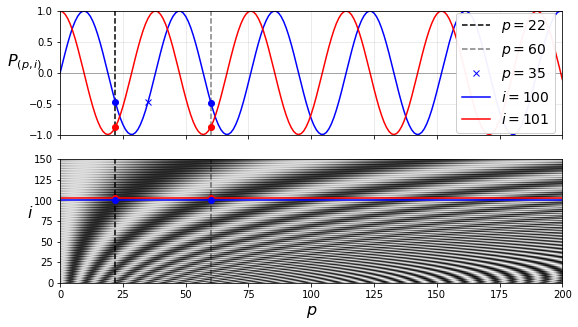

In [83]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

In [84]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

## Simple Transformer

In [85]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

In [86]:
encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

In [87]:
# multihead attention layer
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [88]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])

# End of Chapter Exercises

1. What are the pros and cons of using a stateful RNN versus a stateless RNN?
2. Why do people use Encoder–Decoder RNNs rather than plain sequence-tosequence RNNs for automatic translation?
3. How can you deal with variable-length input sequences? What about variablelength output sequences?
4. What is beam search and why would you use it? What tool can you use to imple‐
ment it?
5. What is an attention mechanism? How does it help?
6. What is the most important layer in the Transformer architecture? What is its
purpose?
7. When would you need to use sampled softmax?
8. Embedded Reber grammars were used by Hochreiter and Schmidhuber in their
paper about LSTMs. They are artificial grammars that produce strings such as
“BPBTSXXVPSEPE.” Check out Jenny Orr’s nice introduction to this topic.
Choose a particular embedded Reber grammar (such as the one represented on
Jenny Orr’s page), then train an RNN to identify whether a string respects that
grammar or not. You will first need to write a function capable of generating a
training batch containing about 50% strings that respect the grammar, and 50%
that don’t.
9. Train an Encoder–Decoder model that can convert a date string from one format
to another (e.g., from “April 22, 2019” to “2019-04-22”).
10. Go through TensorFlow’s Neural Machine Translation with Attention tutorial.
11. Use one of the recent language models (e.g., BERT) to generate more convincing
Shakespearean text.

***1. What are the pros and cons of using a stateful RNN versus a stateless RNN?***
A: 

Stateful Pros:
- Can capture longer-term patterns where stateless can only capture pattern equal to or less than the size of the windows in the RNN.

Cons:
- Harder to implement, especially when preparing the dataset
- Not always the better solution because batches are not independent or identically distributed.

***2. Why do people use Encoder–Decoder RNNs rather than plain sequence-to-sequence RNNs for automatic translation?***
A: Encoder-Decoder RNNs are great for language translation because it reads the entire sentence and then translates it, as opposed to one word at a time with trying to match sequences. Especially in different language, one word may be 2 consecutive words in another language or more. 

***3. How can you deal with variable-length input sequences? What about variable-length output sequences?***
A: To deal with the variability in inputs, one can pad the shorter sequences so that all sequences are of equal length. But then the RNN would see the padding which is a problem. To avoid this, we can then use masking to ignore the padding token. For variable-length outputs, it depends if you know the output sequence. If you do, simply set it so that the loss function ignores tokens after the end of the sentence (Ex. after `<EOS>`). If not, the ideal situation would be to simply have the model output an end-of-sentence token after each sentence.

***4. What is beam search and why would you use it? What tool can you use to imple‐
ment it?***
A: Beam Search is an algorithm where it keeps a running list of the *k* most prominent output setences and at each decoder step in an Encoder-Decoder model, it tries to extend the sentence by one word and keeps the most likely of sentences. This is good for accuracy for sentence translation. This can be implemented in Tensorflow


***5. What is an attention mechanism? How does it help?***
A: An attention mechanism is a technique that can be used in Encoder-Decoder models that helps with longer input sequences. It uses an alignment model to output an alignment score for each decoder step input time step. This helps identify which part of the input is most relevant in the current decoder time step. The weighted sum of the output is fed to the decoder to produce to next decoder step. It helps specifically with longer input sequences getting processed in the model.

***6. What is the most important layer in the Transformer architecture? What is its
purpose?***
A:
The most important is the Multi-Head Attention Layer. It's purpose is to find the appropriate word mappings and the find words that are most aligned with each other and the contextual clues associated with the words as well. 

***7. When would you need to use sampled softmax?***
A: This would be ideal if there were thousands of classes in a classification model. 

In [ ]:
# Question #8
'''8. Embedded Reber grammars were used by Hochreiter and Schmidhuber in their
paper about LSTMs. They are artificial grammars that produce strings such as
“BPBTSXXVPSEPE.” Check out Jenny Orr’s nice introduction to this topic.
Choose a particular embedded Reber grammar (such as the one represented on
Jenny Orr’s page), then train an RNN to identify whether a string respects that
grammar or not. You will first need to write a function capable of generating a
training batch containing about 50% strings that respect the grammar, and 50%
that don’t.'''

An example of a string generator in the form of Reber Grammar is the following:
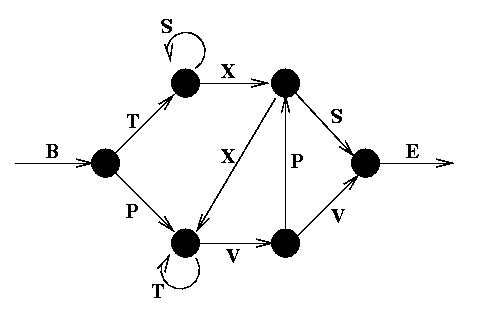

And then on top of that, you could have an embedded reber grammar example:
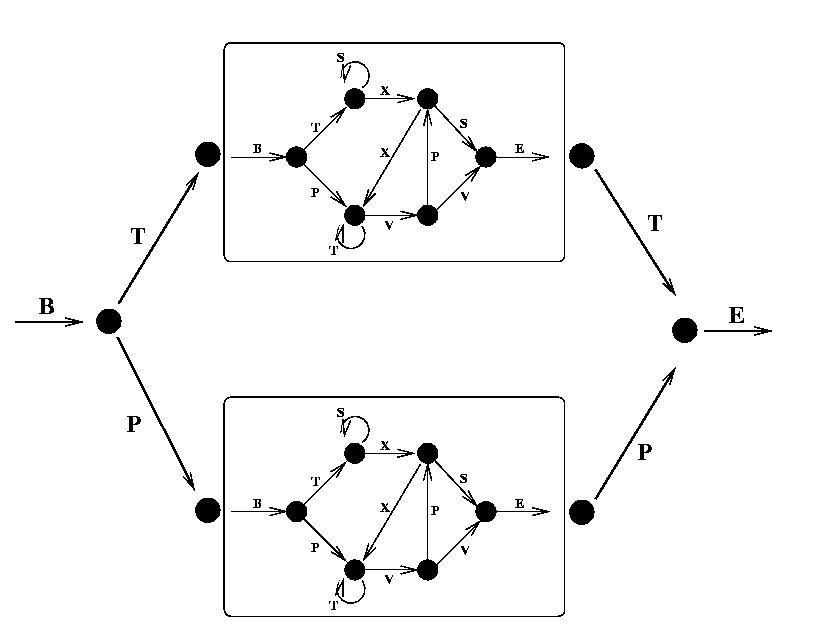

In these string generators, a string that would be considered "reber" is one that conforms to the pattern here up until the final letter. One example is starting at B, then moving to T, then S, Then S again, then X, then S, Then E Or BTSSXSE. One that is not reber would be something like BTSSXPSE because P can only be accessed from V. So from that, we can create an array with our mapping for both a regular reber grammar expression and an embedded reber grammar expression.

In [23]:
reber_grammar = [
    [("B", 1)] ,    # State 0 -> 1
    [("T", 2), ("P", 3)], # State 1 -> State 2 (T) or State 3 (P)
    [("S", 2), ("X", 4)], # State 2 -> State 2 (S Looped) or State 4 (X)
    [("T", 3), ("V", 5)], # State 3 -> State 3 (T Looped) or State 5 (V)
    [("X", 3), ("S", 6)], # State 4 -> State 3 (Diagonal X) or State 6 (S)
    [("P", 4), ("V", 6)], # State 5 -> State 4 (Vertical P) or State 6 (V)
    [("E", None)]] # State 6 -> End terminal state (E)

# Embedded is same exercise as above code but for embedded example
embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(reber_grammar, 4)],
    [(reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

In [24]:
import numpy as np
def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        letter, state = grammar[state][index]
        if isinstance(letter, list):
            letter = generate_string(grammar=letter)
        output.append(letter)
    return "".join(output)

In [25]:
# default reber
for i in range(15):
    print(generate_string(reber_grammar), end=" ")

BPTTTTTTVPXTVPXVPXTTTVVE BPTTTVPXVPSE BPVPXTTTTTVPSE BTSSXSE BPVPSE BTSXSE BPVVE BPVVE BTXSE BTXXTVPXTTVPSE BTSSSXSE BTSXXTTVVE BPTTVVE BPVPSE BTXXVVE 

In [26]:
# embedded reber example
for j in range(15):
    print(generate_string(embedded_reber_grammar), end=" ")

BPBPTVPXTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE BTBTXXVVETE BTBTXSETE BTBPTVPXTVVETE BTBPTTVVETE BTBPVPXVPXVPXVVETE BTBTXSETE BPBPTVVEPE BTBPTVVETE BPBTSXXTTTTTVVEPE 

In [27]:
# Now to list all letters in Reber Grammar Problem and a function that alters 1 letter in group

chars_in_reber = "BEPSTVX"

def alter_string(grammar, chars=chars_in_reber):
    normal_string = generate_string(grammar)
    index = np.random.randint(len(normal_string))
    normal_char = normal_string[index]
    swapped_char = np.random.choice(sorted(set(chars) - set(normal_char)))
    return normal_string[:index] + swapped_char + normal_string[index + 1:]

In [29]:
# altered strings example
for i in range(25):
    print(alter_string(embedded_reber_grammar), end=" ")

BTBPVVEBE BPBPTSVVEPE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS BXBTXSETE BTBTXXVPSPTE BPBTXXEPE BTBPTTVPSETT BTBXXSETE BSBTSXSETE BPBPTTEPXVVEPE 

In [30]:
# Now to encode letters as embeddings
def strings_to_ids(s, chars=chars_in_reber):
    return [chars.index(c) for c in s]

In [34]:
strings_to_ids("BSTETEPSSTEPB")

[0, 3, 4, 1, 4, 1, 2, 3, 3, 4, 1, 2, 0]

In [40]:
import tensorflow as tf
def gen_dataset(size):
    normal_strings = [strings_to_ids(generate_string(embedded_reber_grammar)) for i in range(size // 2)]
    altered_strings = [strings_to_ids(alter_string(embedded_reber_grammar)) for i in range(size- size // 2)]
    all_strings = normal_strings + altered_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for i in range(len(normal_strings))] +
                [[0.] for i in range(len(altered_strings))])
    return X,y

In [41]:
X_train, y_train = gen_dataset(20000)
X_valid, y_valid = gen_dataset(4000)

In [42]:
X_train[0]

<tf.Tensor: shape=(11,), dtype=int32, numpy=array([0, 2, 0, 2, 4, 5, 2, 3, 1, 2, 1])>

In [43]:
y_train[0]

array([1.])

The above means that it is mapped to a normal string for our Reber Grammar strings.

In [54]:
from tensorflow import keras
embedding_size = 32

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(chars_in_reber), output_dim=embedding_size),
    keras.layers.GRU(50),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.93, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid))

Epoch 1/25


D:\Anaconda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_10/gru_13/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_10/gru_13/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_10/gru_13/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


625/625 [==============================] - 86s 137ms/step - loss: 0.6875 - accuracy: 0.5398 - val_loss: 0.6754 - val_accuracy: 0.5375
Epoch 2/25
625/625 [==============================] - 84s 135ms/step - loss: 0.6623 - accuracy: 0.5724 - val_loss: 0.6540 - val_accuracy: 0.6155
Epoch 3/25
625/625 [==============================] - 84s 135ms/step - loss: 0.6473 - accuracy: 0.5932 - val_loss: 0.6460 - val_accuracy: 0.6155
Epoch 4/25
625/625 [==============================] - 83s 132ms/step - loss: 0.6340 - accuracy: 0.6133 - val_loss: 0.6275 - val_accuracy: 0.6423
Epoch 5/25
625/625 [==============================] - 84s 134ms/step - loss: 0.6145 - accuracy: 0.6497 - val_loss: 0.5991 - val_accuracy: 0.6660
Epoch 6/25
625/625 [==============================] - 79s 126ms/step - loss: 0.5496 - accuracy: 0.7182 - val_loss: 0.4483 - val_accuracy: 0.8175
Epoch 7/25
625/625 [==============================] - 82s 132ms/step - loss: 0.3417 - accuracy: 0.8638 - val_loss: 0.1531 - val_accuracy: 0.9

In [56]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([strings_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.06%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.98%


In [ ]:
# Question 9
'''9. Train an Encoder–Decoder model that can convert a date string from one format
to another (e.g., from “April 22, 2019” to “2019-04-22”).'''

In [4]:
from datetime import date

# Set months in list 
Months =  ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def make_random_date(date_n):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()
    
    ordinals = np.random.randint(max_date - min_date, size=date_n) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]
    
    X = [Months[dat.month - 1] + " " + dat.strftime("%d, %Y") for dat in dates]
    y = [dat.isoformat() for dat in dates]
    return X, y

In [5]:
# random example dates

num = 3
X_examples, y_examples = make_random_date(num)
print("{:25s}{:25s}".format("Input","Target"))
print("-" * 50)
for i in range(num):
    print("{:25s}{:25s}".format(X_examples[i], y_examples[i]))


Input                    Target                   
--------------------------------------------------
July 06, 9334            9334-07-06               
August 20, 7104          7104-08-20               
December 16, 3659        3659-12-16               


Now that we see it is working, let's grab all possible character for inputs that our model may recieve:

In [7]:
inputs = "".join(sorted(set("".join(Months) + "0123456789, ")))
inputs

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [8]:
# Now for outputs
outputs = "0123456789-"

In [9]:
# Function to convert string to ids (embeddings)
# Can reuse function used in #8 and change a bit
def date_strings_to_ids(date_strings, chars=inputs):
    return [chars.index(c) for c in date_strings]

In [11]:
date_strings_to_ids(X_examples[0], inputs)

[15, 35, 27, 37, 0, 2, 8, 1, 0, 11, 5, 5, 6]

In [13]:
date_strings_to_ids(y_examples[0], outputs)

[9, 3, 3, 4, 10, 0, 7, 10, 0, 6]

In [14]:
# similar functions to #8

def prepare_dates(date_strs, chars=inputs):
    X_s = [date_strings_to_ids(dat, chars) for dat in date_strs]
    X = tf.ragged.constant(X_s, ragged_rank=1)
    return (X + 1).to_tensor()

def create_dataset(date_n):
    X, y = make_random_date(date_n)
    return prepare_dates(X, inputs), prepare_dates(y, outputs)

In [15]:
X_train, Y_train = create_dataset(20000)
X_valid, Y_valid = create_dataset(4000)
X_test, Y_test = create_dataset(4000)

In [16]:
Y_train[1]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 4,  7,  9,  3, 11,  2,  3, 11,  2, 10])>

Time to build our sequence to sequence model now. We will use an LSTM model to assist where the input will go through an encoder which will give us a vector, then the input goes through a decoder with a sequence of probabilities in the form of vectors for each possible character output and then repeat each vector (which is our output by the encoder) for the longest possible output sequence. This means, it will repeat that vector for n times of the longest sequence:

In [21]:
embedding_size = 32
output_length = Y_train.shape[1]

model_encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(inputs) + 1,
                           output_dim = embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

model_decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(outputs) + 1, activation="softmax")
])

model = keras.models.Sequential([
    model_encoder,
    keras.layers.RepeatVector(output_length),
    model_decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
625/625 [==============================] - 23s 20ms/step - loss: 1.5692 - accuracy: 0.4349 - val_loss: 1.2158 - val_accuracy: 0.5669
Epoch 2/20
625/625 [==============================] - 10s 16ms/step - loss: 1.0360 - accuracy: 0.6305 - val_loss: 1.5119 - val_accuracy: 0.4891
Epoch 3/20
625/625 [==============================] - 9s 15ms/step - loss: 0.6856 - accuracy: 0.7368 - val_loss: 0.4644 - val_accuracy: 0.8112
Epoch 4/20
625/625 [==============================] - 9s 15ms/step - loss: 0.4344 - accuracy: 0.8321 - val_loss: 0.2599 - val_accuracy: 0.9074
Epoch 5/20
625/625 [==============================] - 11s 17ms/step - loss: 0.2995 - accuracy: 0.9119 - val_loss: 0.1673 - val_accuracy: 0.9596
Epoch 6/20
625/625 [==============================] - 10s 16ms/step - loss: 0.0941 - accuracy: 0.9822 - val_loss: 0.0411 - val_accuracy: 0.9961
Epoch 7/20
625/625 [==============================] - 10s 16ms/step - loss: 0.1078 - accuracy: 0.9750 - val_loss: 0.1017 - val_accuracy: 0

In [36]:
X_new = prepare_dates(["September 30, 2019", "April 6, 1995", "May 28, 2016", "November 11, 2002"])

In [37]:
def ids_to_date_strings(ids, chars=outputs):
    return ["".join([("$" + chars)[index] for index in sequence]) # use dollar sign as random character to replace spaces
            for sequence in ids]

In [38]:
ids = np.argmax(model.predict(X_new), axis=-1)
for dates in ids_to_date_strings(ids):
    print(dates)

2019-09-30
1955-04-16
2016-05-28
2002-11-11


Looks like the model has difficulties with shorter input strings such as "April 6, 1995" because the longest length date was of size 18. So we must create a new function to assist:

In [45]:
max_input_shape = X_train.shape[1]

def padded_dates(dates):
    X = prepare_dates(dates)
    if max_input_shape > X.shape[1]:
        X = tf.pad(X, [[0, 0], [0, max_input_shape - X.shape[1]]])
    return X

def convert_date_strs(dates):
    X = padded_dates(dates)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strings(ids)

In [46]:
convert_date_strs(["April 6, 1995", "July 27, 1956"])

['1955-04-16', '1956-07-27']

In [1]:
# Question 10
'''10. Go through TensorFlow’s Neural Machine Translation with Attention tutorial.'''

The following example is a notebook by Tensorflow where the goal is to train a sequence to sequence (seq2seq) model for Spanish to English Translation.

In [3]:
#pip install "tensorflow-text==2.8.*"

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import typing
from typing import Any, Tuple
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
use_builtins = True

In [2]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

## The dataset

We are using a dataset from http://www.manythings.org/anki/ with language translation pairs in english and spanish

In [3]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
# fucntion to load in the data
def load_data(path):
    text = path.read_text(encoding='utf-8')
    
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    
    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]
    
    return targ, inp

In [5]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [6]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


## Time to create a tf.data dataset from this in the form of tensor slices

In [7]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [8]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'\xc2\xbfT\xc3\xba crees que me tengo que ir?'
 b'Ella no reconoce que est\xc3\xa1 equivocada.'
 b'Respira de forma normal.' b'Odio la pol\xc3\xadtica.'
 b'Tom\xc3\xa1s parece estar frustrado.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Do you think I need to go?' b"She doesn't admit that she is wrong."
 b'Breathe normally.' b'I hate politics.' b'Tom looks frustrated.'], shape=(5,), dtype=string)


## Standardization

For standardizing our multilingual text, we will split accented characters and replace compatibility characters with their ASCII equivalents.

In [9]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [10]:
# Function to automate process
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add extra spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Stripping out whitespace
    text = tf.strings.strip(text)
    
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [11]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


## Text Vectorization

In [12]:
# Wrap above function in tf.keras.layers.TextVectorization layer for vocab extractoin/conversion

max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
                    standardize=tf_lower_and_split_punct,
                    max_tokens=max_vocab_size)

The TextVectorization layer and many other preprocessing layers have an adapt method. This method reads one epoch of the training data, and works a lot like Model.fix. This adapt method initializes the layer based on the data. Here it determines the vocabulary:

In [13]:
input_text_processor.adapt(inp)

# First ten words from vocab
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [14]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [15]:
# Now the layers can convert batch of strings into batch of token IDs

example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   13,   36,  317,    5,   18,   49,    5,   68,   12],
       [   2,   29,    9,    1,    5,   20, 1914,    4,    3,    0],
       [   2, 3703,    6,  556, 1208,    4,    3,    0,    0,    0]],
      dtype=int64)>

In [16]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()] # convert tokens back to text
' '.join(tokens)

'[START] ¿ tu crees que me tengo que ir ? [END]       '

Text(0.5, 1.0, 'Mask')

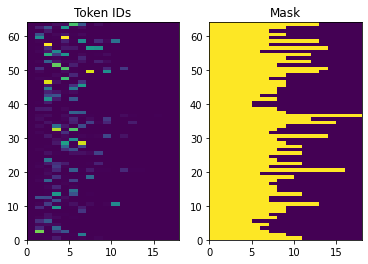

In [17]:
# Visualization

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title("Mask")

## Encoder/Decoder Model

Overview of encoder/decoder model
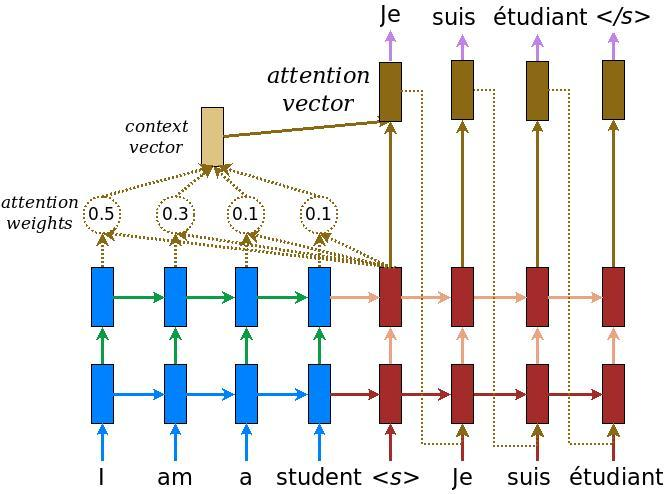


In [18]:
# Model Constants

embedding_dim = 256
units = 1024

## Building the Encoder

The encoder:

1. Takes a list of token IDs (from input_text_processor)
2. Looks up an embedding vector for each token (Using a layers.Embedding).
3. Processes the embeddings into a new sequence (Using a layers.GRU())
4. Returns:
    - The processed sequences. This will be passed to the attention head.
    - The internal state. This will be used to initialize the decoder.

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)
        
        # The GRU RNN Layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                      # Return the sequence and state
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
    
    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        
        # 2. THe embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        
        # 3. The GRU processes the embedding sequence. 
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        
        # 4. Returns the new sequence and its state.
        return output, state

In [20]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 18)
Encoder output, shape (batch, s, units): (64, 18, 1024)
Encoder state, shape (batch, units): (64, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

### The Attention Head

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a layers.GlobalAveragePooling1D but the attention layer performs a weighted average.

Let's look at how this works:

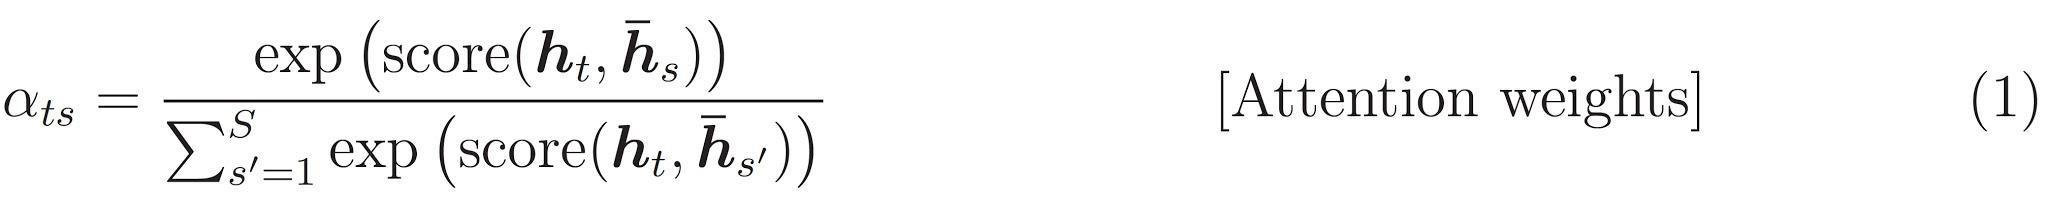

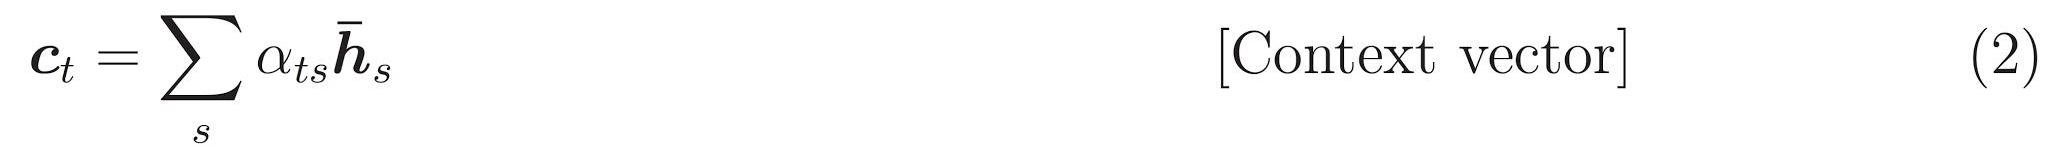

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the `score` function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

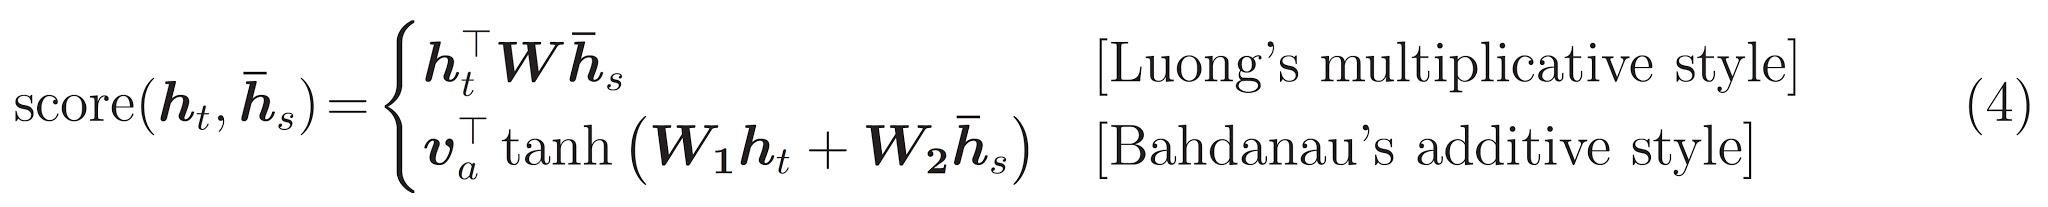

In this exercise, we will use Bahdanau's additive attention:

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        
        self.attention = tf.keras.layers.AdditiveAttention()
        
    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        
        # From Eqn. (4) Multiplication for W1@ht
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        
        # From Eqn. (4) Multiplication for W2@hs
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        
        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask = [query_mask, value_mask],
            return_attention_scores = True,        
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [22]:
# Test for attention layer
attention_layer = BahdanauAttention(units)

In [23]:
(example_tokens != 0).shape

TensorShape([64, 18])

With a vectorized implementation of the attention layers, we pass a batch of sequences of query  vectors and a batch of sequences of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch attention maps, with size `(query_length, value_length)`

In [24]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 18)


Text(0.5, 1.0, 'Mask')

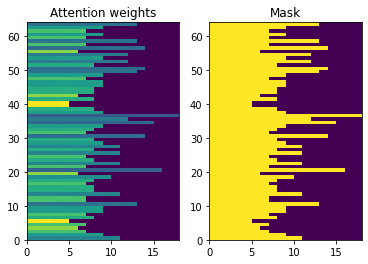

In [25]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [26]:
attention_weights.shape

TensorShape([64, 2, 18])

In [27]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

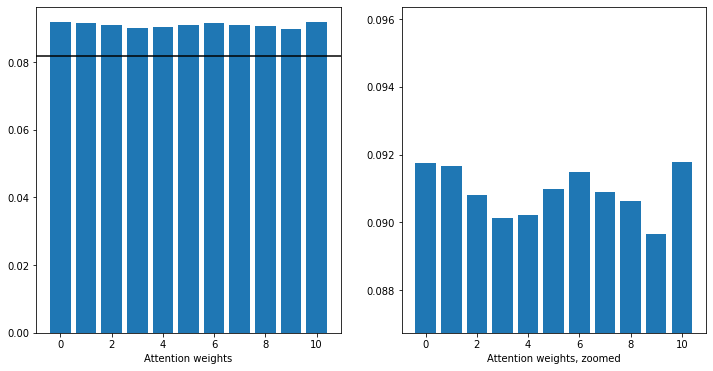

In [28]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

## The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3(below) to geenrate the "attention vector".
5. It generates logic predictions for the next token based on the "attention vector."

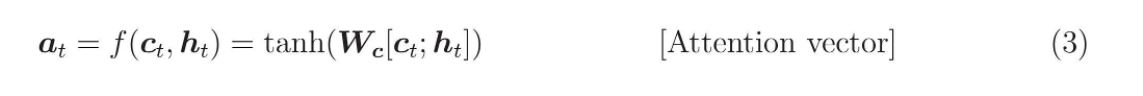

In [29]:
# Decoder class
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        
        # For Step 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)
        
        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
        
        #For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)
        
        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh, use_bias=False)
        
        # For step 5. This fully connected layer produces the logits for each output token
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [30]:
# Seperate classes for Decoder input and output
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any
        
class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [31]:
# Call method
def call(self,inputs: DecoderInput,state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))
    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))
    
    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))
    
    # Step 2. Process one step with RNN
    rnn_output, state, = self.gru(vectors, initial_state=state)
    
    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))
    
    # Step 3. Use the RNN output as the query for the attention over the encoder output
    context_vector, attention_weights = self.attention(query=rnn_output, 
                                                      value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))
    
    # Step 4. Eqn (3): Join the context_vector and rnn_output
    # [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    
    # Step 4 Eqn(3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))
    
    # Step 5 Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))
    
    return DecoderOutput(logits, attention_weights), state

In [32]:
Decoder.call = call

The encoder processes its full input sequence with a single call to its RNN. THis implementation of the decoder can do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

- Flexibility: Writing the loop gives you direct control over the training procedure.
- Clarity: It's possible to do masking tricks and use layers.RNN or tfa.seq2seq APIs to pack this all into a single call. But writing it out as a loop may be clearer.

In [33]:
# Using the decoder
decoder = Decoder(output_text_processor.vocabulary_size(),
                 embedding_dim, units)

The decoder takes 4 inputs.

- new_tokens - The last token generated. Initialize the decoder with the "[START]" token.
- enc_output - Generated by the Encoder.
- mask - A boolean tensor indicating where tokens != 0
- state - The previous state output from the decoder (the internal state of the decoder's RNN). Pass None to zero-initialize it. The original paper initializes it from the encoder's final RNN state.

In [34]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [35]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [36]:
# sampling a token according to the logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [37]:
# decode token as first word of output
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['snowed'],
       ['predict'],
       ['canadian'],
       ['order'],
       ['translated']], dtype='<U16')

Now we will use the decoder to generate a second set of logits:
- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`
- Pass the decoder_state the decoder returned last time, so the RNN continues with a memory of where it left off last time.

In [38]:
dec_result, dec_state = decoder(DecoderInput(sampled_token, example_enc_output, mask=(example_tokens != 0)),
                               state=dec_state)

In [39]:
samples_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['snowed'],
       ['predict'],
       ['canadian'],
       ['order'],
       ['translated']], dtype='<U16')

## Training the model

In [40]:
# Creating a loss function with a python class
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    
    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        
        # Calculate the loss for each item in the batch
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        
        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask
        
        # Return total 
        return tf.reduce_sum(loss)

In [41]:
# Creating a model class for our training process

class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units, input_text_processor, output_text_processor,
                use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                         embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                         embedding_dim, units)
        
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()
    
    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

Overall the implementation for the Model.train_step method is as follows:

1. Receive a batch of input_text, target_text from the tf.data.Dataset.
2. Convert those raw text inputs to token-embeddings and masks.
3. Run the encoder on the input_tokens to get the encoder_output and encoder_state.
4. Initialize the decoder state and loss.
5. Loop over the target_tokens:
       a. Run the decoder one step at a time.
       b. Calculate the loss for each step.
       c. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.

The _preprocess method, added below, implements steps #1 and #2:

In [42]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))
    
    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))
    
    # Convert IDs to masks
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))
    
    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))
    
    return input_tokens, input_mask, target_tokens, target_mask

In [43]:
TrainTranslator._preprocess = _preprocess

The _train_step Method, added below, handles the remaining steps except for actually running the decoder

In [44]:
def _train_step(self, inputs):
    input_text, target_text = inputs
    
    (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_text, target_text)
    
    max_target_length = tf.shape(target_tokens)[1]
    
    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))
        
        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of units
        dec_state = enc_state
        loss = tf.constant(0.0)
        
        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask, enc_output, dec_state)
            loss = loss + step_loss
        
        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
        
    # Apply an optimization step
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    
    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [45]:
TrainTranslator._train_step = _train_step

The _loop_step method, added below, executes the decoer and calculates the incremental loss and new decoder state (dec_state)

In [46]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)
    
    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))
    
    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    
    return step_loss, dec_state

In [47]:
TrainTranslator._loop_step = _loop_step

Build instance of TrainTranslator and configure it for training using the Model.compile method

In [48]:
translator = TrainTranslator(embedding_dim, units, input_text_processor=input_text_processor,
                            output_text_processor=output_text_processor,use_tf_function=False)

# Configure the loss and optimizer
translator.compile(optimizer=tf.optimizers.Adam(),loss=MaskedLoss(),)

In [49]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [50]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5931897>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5614405>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.501214>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3311467>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.735949>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9676037>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5773706>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3771634>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.077384>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9319928>}

Wall time: 5.52 s


In [51]:
# Now to wrap out _tf_train_step in a @tf.function
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                              tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [52]:
TrainTranslator._tf_train_step = _tf_train_step

In [53]:
translator.use_tf_function = True

In [54]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9168127>}

In [55]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8733451>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7984238>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7452612>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6660483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.589814>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5472717>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.479901>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4408247>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.371723>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3103442>}

Wall time: 4.14 s


....................................................................................................


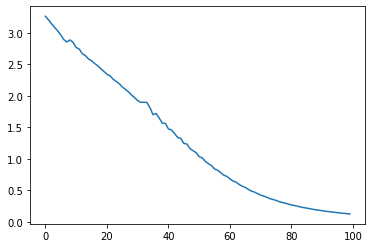

In [56]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now after seeing the results, we can build a new copy to train from scratch:

In [57]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

## Creating a Callback Method

We can now create a callback method to collect the history of batch losses for plotting:

In [58]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []
        
    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [59]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 893s 478ms/step - batch_loss: 2.0607
Epoch 2/3
1859/1859 [==============================] - 887s 477ms/step - batch_loss: 1.0413
Epoch 3/3
1859/1859 [==============================] - 893s 480ms/step - batch_loss: 0.8141


Text(0, 0.5, 'CE/token')

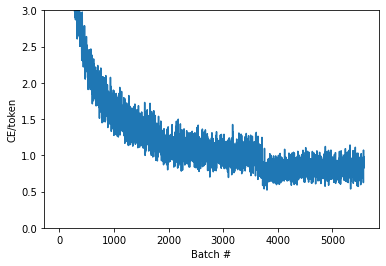

In [60]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

## Translator Function Implementation

Now that the model is trained, implement a function to execute the full `text => text `translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [61]:
class Translator(tf.Module):
    
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder 
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        
        self.output_token_string_from_index = (tf.keras.layers.StringLookup(vocabulary=
                                                                           output_text_processor.get_vocabulary(),
                                                                           mask_token='',
                                                                           invert=True))
        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        
        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [62]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

## Converting token IDs to text

In [63]:
# function that converts from token IDs to human readable text.
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))
    
    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    shape_checker(result_text, ('batch'))
    
    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

In [64]:
Translator.tokens_to_text = tokens_to_text

In [65]:
# See what some random token IDs generate
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'mobile engaged', b'cigarette flush', b'acknowledged monkeys',
       b'verdict construction', b'direct tiring'], dtype=object)

## Samples from decoder predictions

The following function takes the decoder's logit outputs and samples token IDs from that distribution:

In [66]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))
    
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
    
    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)
    
    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
        
    shape_checker(new_tokens, ('batch', 't'))
    
    return new_tokens

In [67]:
Translator.sample = sample

In [68]:
# Testing on random inputs
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[3729],
       [ 721],
       [1438],
       [1332],
       [1422]], dtype=int64)>

## Implementing the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using tf.concat to join them into tensors.

This implementation statically unrolls the graph out to max_length iterations. This is okay with eager execution in python.

In [71]:
def translate_unrolled(self, input_text, *, max_length=50, return_attention=True,
                      temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    
    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    
    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens,
                                enc_output=enc_output,
                                 mask=(input_tokens!=0))
        
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        
        attention.append(dec_result.attention_weights)
        
        new_tokens = self.sample(dec_result.logits, temperature)
        
        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        
        # Collect the generated tokens 
        result_tokens.append(new_tokens)
        
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
            
    # Convert the list of generated token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text =  self.tokens_to_text(result_tokens)
    
    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [72]:
Translator.translate = translate_unrolled

In [75]:
# Run it on a simple input
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

Wall time: 474 ms


To be able to export this model, we need to wrap this method in a tf.function. This basic implementation has a few issues though:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run max_length iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.

In [76]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

In [79]:
%%time
result = translator.tf_translate(
    input_text = input_text)

Wall time: 14.9 s


In [80]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it makes a cold here .
this is my life .

Wall time: 346 ms


In [81]:
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ('batch',))

    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_processor(input_text)
    shape_checker(input_tokens, ('batch', 's'))

    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ('batch', 's', 'enc_units'))
    shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ('batch', 't1'))

    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ('batch', 't1'))

    for t in tf.range(max_length):
        dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        attention = attention.write(t, dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
        shape_checker(new_tokens, ('batch', 't1'))

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens = result_tokens.write(t, new_tokens)

        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ('t', 'batch', 't0'))
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ('batch', 't'))

    result_text = self.tokens_to_text(result_tokens)
    shape_checker(result_text, ('batch',))

    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ('t', 'batch', 's'))

        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ('batch', 't', 's'))
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [82]:
Translator.translate = translate_symbolic

In [83]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

Wall time: 344 ms


In [84]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

In [85]:
%%time
result = translator.tf_translate(
    input_text = input_text)

Wall time: 1.11 s


In [86]:
#Using compiled function
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it is a nice cold here .
this isnt my life .

Wall time: 239 ms


## Visualizing the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [87]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         0.99999994 0.99999994 1.         1.0000001  1.
 0.99999994 1.        ]


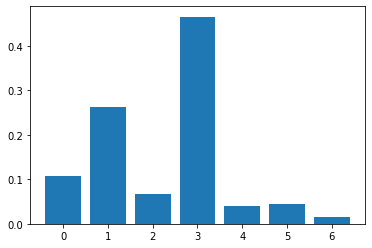

In [88]:
gph = plt.bar(range(len(a[0, :])), a[0, :])

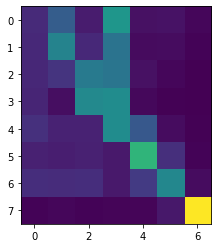

In [89]:
plt.imshow(np.array(a), vmin=0.0)

In [90]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

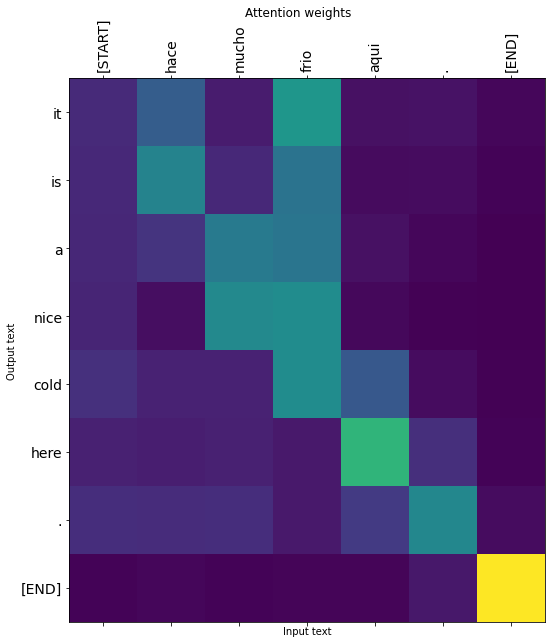

In [91]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Now to translate a few more sentences and plot them:

In [93]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
try in figure out how to just handle it .

Wall time: 186 ms


In [94]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are you still at home ?',
       b'try in figure out how to just handle it .'], dtype=object)>

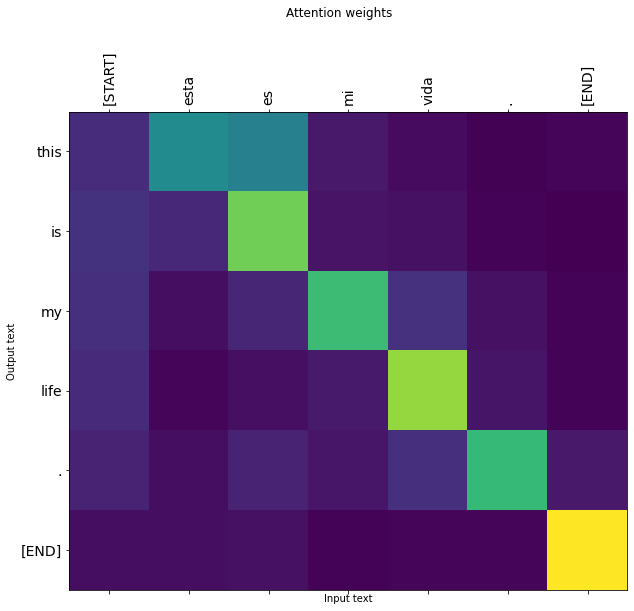

In [95]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

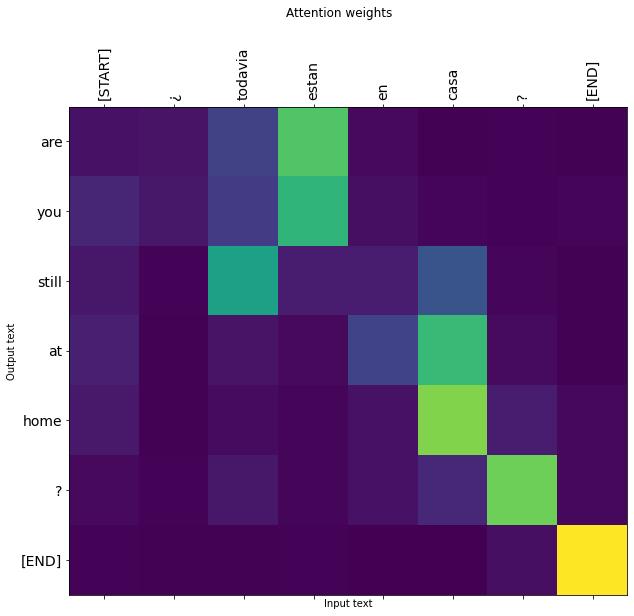

In [96]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

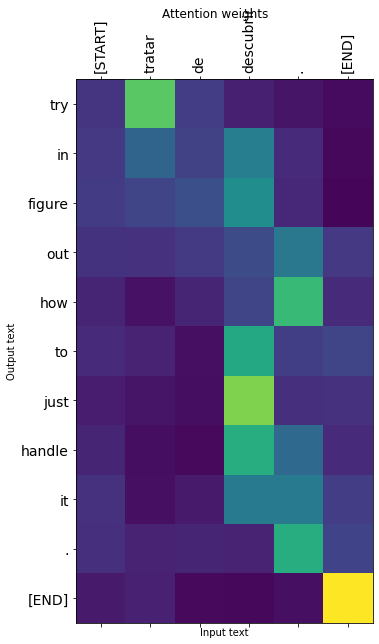

In [97]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. Transformers solve this by using self-attention in the encoder and decoder.

In [98]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


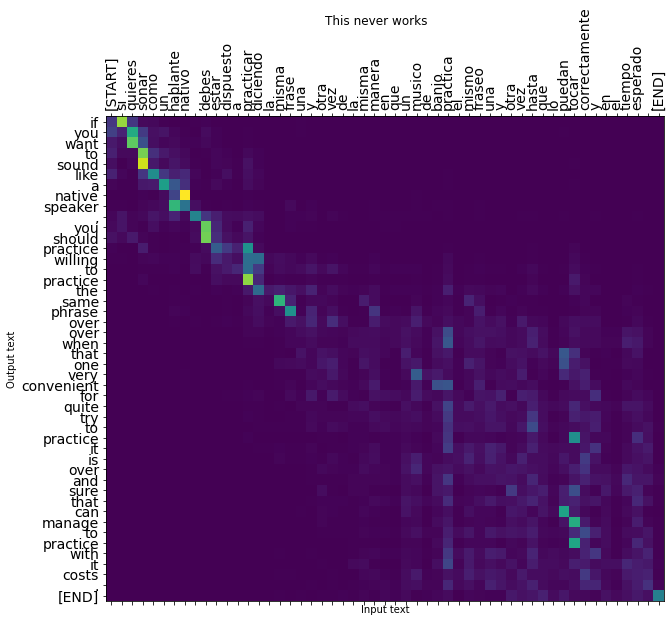

In [99]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

In [100]:
# Export the model 
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets


In [101]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [104]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

this is my life .
is they still at home ?
just warn find .

Wall time: 340 ms


In [3]:
# Question 11
'''11. Use one of the recent language models (e.g., BERT) to generate more convincing
Shakespearean text.'''

In [1]:
!pip install transformers

In [2]:
# Question 11
'''11. Use one of the recent language models (e.g., BERT) to generate more convincing
Shakespearean text.'''
# Had a lot of difficulties trying to ue GPT2, so in this case let's use GTP model 
import tensorflow as tf
#!pip install transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# using tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Initializing a model from the configuration
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

In [124]:
prompt = '''Now cracks a noble heart. Good night, sweet prince,
            and flights of angels sing thee to thy rest.'''

encoded_prompt = tokenizer.encode(prompt, return_tensors="pt")
encoded_prompt

tensor([[ 3844, 23217,   257, 15581,  2612,    13,  4599,  1755,    11,  6029,
         19716,    11,   198,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   290, 13956,   286, 21981,  1702, 17903,
           284, 11906,  1334,    13]])

In [125]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

tensor([[ 3844, 23217,   257, 15581,  2612,    13,  4599,  1755,    11,  6029,
         19716,    11,   198,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   290, 13956,   286, 21981,  1702, 17903,
           284, 11906,  1334,    13,   198,   198,  1212,   582,    11, 14210,
          7927,    12,   805,    11,  5316,   318,  6613,   286, 17903,     0,
          2236,   523,   881,  5938, 17903,    13,   843,   611,   345,  2236,
           407,  2148,   329, 11906,  9089,    11, 11906,  3189,  2236,   307,
           644,   340,   318,    11],
        [ 3844, 23217,   257, 15581,  2612,    13,  4599,  1755,    11,  6029,
         19716,    11,   198,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   290, 13956,   286, 21981,  1702, 17903,
           284, 11906,  1334,    13,   198,   198,   818, 15393,   286,   262,
          1467,   400,  7235,   286,   536, 19942,   198,   198,    46,  6029,
         19716

In [126]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

Now cracks a noble heart. Good night, sweet prince,
            and flights of angels sing thee to thy rest.

This man, thou vice-man, justice is proud of thee! shall so much hurt thee. And if you shall not provide for thy losses, thy conduct shall be what it is,
--------------------------------------------------------------------------------
Now cracks a noble heart. Good night, sweet prince,
            and flights of angels sing thee to thy rest.

In honour of the 16th Blood of Thorns

O sweet prince of thine heart! Your lordship,

By this, I have come to ask your aid and in
--------------------------------------------------------------------------------
Now cracks a noble heart. Good night, sweet prince,
            and flights of angels sing thee to thy rest. And for this land be not condemned. Therefore, this land be pardoned, an day a year. To men, if thou be willing to say this, There are of thee four treasures which are
---------------------------------------------------------